# Machine Learning with scikit-learn

Sometimes the features you have available in your initial data have little predictive strength when used in the most straightforward way.  This might be true almost regardless of choice of model class and hyperparameters.  And yet it might also be true that there are synthetic features latent in the data that are highly predictive, but that have to be *engineered* (mechanically, rather than sample-wise modification) to produce powerful features.

At the same time, a highly dimension model—whether of high dimension because of the initial data collection or because of creation of extra synthetic features—may lend itself less well to modeling techniques.  In these cases, it can be more computationally tractable, as well as more predictive, to work with a subset of all available features.

We will spend several lessons that can be thought of broadly as "Feature Engineering."  This first lesson focuses on *decompositions*.

In [ ]:
%matplotlib inline
from src.setup import *
from src.whiten import data, show

## Dimensionality reduction

There are two general approaches to *reducing* the number of dimensions (i.e. features) in a dataset.  One is by creating synthetic features that globally combine the raw features.  Several different mathematical techniques are available for doing this.

The other means by which we might reduce dimensions is simply by discarding ones that seem to have little significance to the model.  Very often models actually perform *better* by removing features that are either purely independent of the target or are largely redundant with other features (i.e. highly correlated).  In every case, models can be trained *faster* with fewer dimensions.

## Decomposition

PCA is the oldest and most widely used method for decomposition of dimensional information.  Other methods of decomposition are also provided by scikit-learn.  In broad concept they do something similar, but each shows strengths relative to different datasets; understanding the difference is a mixture of domain familiarity and trial-and-error.

### Miscellaneous decompositions

This lesson will not specifically discuss all of the decomposition classes available in `sklearn.decomposition`.  A complete list with brief descriptions from the [documentation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) is below.  The discussion and examples of reconstructed faces in the [user guide](http://scikit-learn.org/stable/modules/decomposition.html) is very useful.

| Class name          | Description
|---------------------|------------------------------------
| DictionaryLearning  | Dictionary learning
| FactorAnalysis      | Factor Analysis (FA)
| FastICA             | FastICA: a fast algorithm for Independent Component Analysis.
| IncrementalPCA      | Incremental principal components analysis (IPCA).
| KernelPCA           | Kernel Principal component analysis (KPCA)
| LatentDirichletAllocation | Latent Dirichlet Allocation with online variational Bayes algorithm
| MiniBatchDictionaryLearning | Mini-batch dictionary learning
| MiniBatchSparsePCA  | Mini-batch Sparse Principal Components Analysis
| NMF                 | Non-Negative Matrix Factorization (NMF)
| PCA                 | Principal component analysis (PCA)
| SparsePCA           | Sparse Principal Components Analysis (SparsePCA)
| SparseCoder         | Sparse coding
| TruncatedSVD        | Dimensionality reduction using truncated SVD (aka LSA).
| dict_learning       | Solves a dictionary learning matrix factorization problem.
| dict_learning_online| Solves a dictionary learning matrix factorization problem online.
| fastica             | Perform Fast Independent Component Analysis.
| sparse_encode       | Sparse coding


## Principal component analysis (PCA)

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The transformation is defined in such a way that the first principal component accounts for as much of the variability in the data as possible, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

An explanation written by [Hernán Eche for Stack Exchange](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) contained a very nice animation illustrating minimization of variance to find a first principal component. It is easier to understand with a 2-D parametric space, as in the animation.

![PCA animation](PCA-animation-2.gif)

Let us look at sample data. We will choose the Wisconsin breast cancer dataset we worked with in a previous lesson.  Recall that it has 30 features measuring a variety of numeric medical diagnostic results.

First thing, we load the dataset and apply standard scaling to the features.  Later in this lesson we will talk more about scaling, and we have brushed on it in a few previous lessons.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

Perform a standard train/test split as we have with almost all models.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, cancer.target, random_state=1)

For pending comparison, let us remind ourselves of how the raw data preforms using two classifers: `LinearRegression` and `KNeighborsClassifier`.

In [ ]:
from sklearn.linear_model import LinearRegression
(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.7222686011972143

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
(KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.951048951048951

Now we transform the parametric space of the features into just two dimensions that contain the maximum amount of information that **can be** represented in two dimensions.

In [ ]:
cancer.data.shape

(569, 30)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: %s" % str(X_scaled.shape))
print("Reduced shape: %s" % str(X_pca.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


In [ ]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

Looking at a scatter plot, we can see that just two dimensions already get rather good differentiation visually.  Notice that these two components each represent an arbitrary combination of all the actual observational measurements in the dataset.  Therefore, they do not have any obvious English description other than "first component" and "second component."

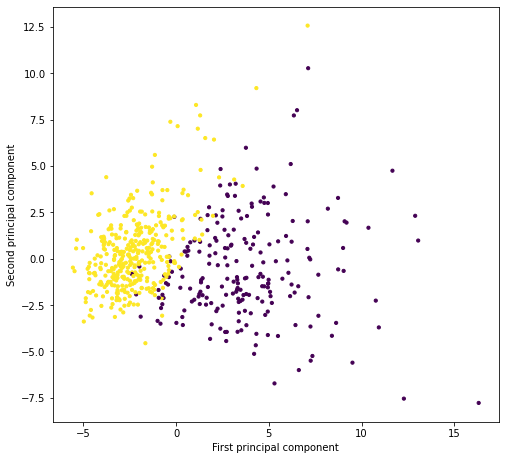

In [ ]:
# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
            c=cancer.target, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

With just two components retained, the linear regression performs a bit worse, but KNN (that is much stronger so far for this data, in any case), performs basically equally well as with all 30 dimensions.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, cancer.target, random_state=1)

In [ ]:
(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.6279864206553516

In [ ]:
(KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.9440559440559441

We can see how the two PCA components are derived by linear combination of the original 30.

In [ ]:
print(pca.components_)

[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Or more visually (but only some original features shown for legibility):

<Figure size 1440x1080 with 0 Axes>

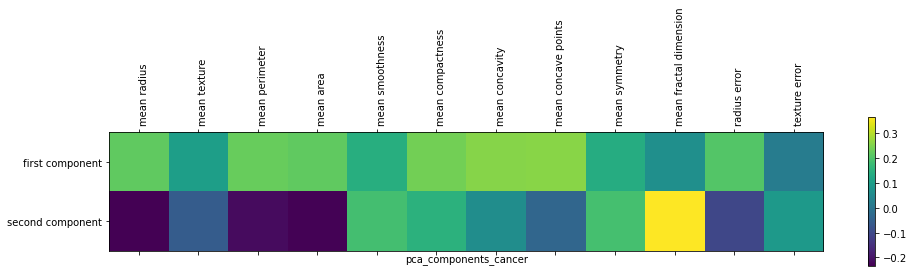

In [ ]:
# Not all original features shown...
nfeat = 12
plt.figure(figsize=(20,15))
plt.matshow(pca.components_[:,:nfeat], cmap='viridis')
plt.yticks([0, 1], ["first component", "second component"])
plt.colorbar()
plt.xticks(range(nfeat),
           cancer.feature_names[:nfeat], rotation=90, ha='left');
plt.xlabel("pca_components_cancer");

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=57949008-d14a-4ee2-8f47-e94cc0939f85' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>